## We would like to compare the data before and after all of our preprocessing to make sure that data appear as we would expect them to.
We'll start by loading some data from petastorm:

In [2]:
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt
from src.data.make_petastorm_dataset import spark_timezone

In [3]:
PROCESSED_DATA_LOCATION = "/projects/bdata/datasets/gatesfoundation/processed/split/audere_split_2020-02-10/train_minute_no_scale_7_days_petastorm/"
first_processed_partition = glob(PROCESSED_DATA_LOCATION + "/*.parquet")[0]
first_processed_partition_df = pd.read_parquet(first_processed_partition)
# first_processed_partition_df = pd.concat([first_processed_partition_df, 
#                                           pd.json_normalize(first_processed_partition_df["window"]).apply(pd.to_datetime)], axis=1)

In [4]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

import pyspark.sql.types as sql_types
from pyspark.sql import functions as f
from pyspark.sql.functions import col

from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark import SparkContext

SPARK_CONFIG = [ 
    ("spark.master","local[16]"),
    ("spark.ui.port","4050"),
    ("spark.executor.memory","16g"),
    ('spark.driver.memory',  '64g'),
    ("spark.driver.maxResultSize", '0'), # unlimited
    ("spark.network.timeout",            "10000001"),
    ("spark.executor.heartbeatInterval", "10000000")]   

conf = SparkConf().setAll(SPARK_CONFIG)
sc = SparkContext(conf=conf, appName="PetaStorm Conversion")
spark = SparkSession(sc)

21/12/14 12:04:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/14 12:04:34 WARN Utils: Service 'SparkUI' could not bind on port 4050. Attempting port 4051.


In [5]:
RAW_DATA_PATH = "/homes/gws/mikeam/seattleflustudy/data/raw/audere/data-export/2020-07-15/activity/fitbit_minute_level_activity"
window_to_compare = first_processed_partition_df.sample(10,random_state=10).iloc[0]
window_to_compare

participant_id                         99fdf97c1b86946e81e1df9f28e3ce8d
window                {'start': 1579132800000000000, 'end': 15797376...
steps                 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
heart_rate            [74.0, 74.0, 75.0, 75.0, 76.0, 76.0, 0.0, 0.0,...
missing_heart_rate    [False, False, False, False, False, False, Tru...
missing_steps         [False, False, False, False, False, False, Fal...
sleep_classic_0       [False, False, False, False, False, False, Fal...
sleep_classic_1       [True, True, True, True, True, True, True, Tru...
sleep_classic_2       [False, False, False, False, False, False, Fal...
sleep_classic_3       [False, False, False, False, False, False, Fal...
count_col                                                         10080
start                                               2020-01-16 00:00:00
end                                                 2020-01-23 00:00:00
id                                                        142592

In [6]:
with spark_timezone("UTC"):
    raw_df = spark.read.parquet(RAW_DATA_PATH)
    raw_df.printSchema()

root
 |-- participant_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- steps: integer (nullable = true)
 |-- sleep_classic: integer (nullable = true)
 |-- heart_rate: integer (nullable = true)



In [7]:
compare_participant = window_to_compare["participant_id"]
raw_compare = raw_df.filter(f.col("participant_id") == compare_participant).toPandas()

In [8]:
raw_compare = raw_compare.sort_values("timestamp")

Text(0, 0.5, 'Heart Rate')

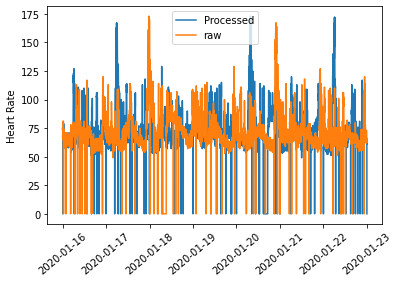

In [9]:
def plot_window(data,start,end,**plt_kwargs):
    x = pd.date_range(start,end,freq="min",closed="right")
    plt.plot(x,data,**plt_kwargs)

def plot_data_in_range(data,start,end,col="heart_rate", time_offset = "0s",**plt_kwargs):
    data_range = data[data["timestamp"].between(start,end)]
    plt.plot(data_range["timestamp"] + pd.to_timedelta(time_offset), data_range[col], **plt_kwargs)

plot_window(window_to_compare["heart_rate"], window_to_compare["start"], window_to_compare["end"],label="Processed")
plot_data_in_range(raw_compare,window_to_compare["start"], window_to_compare["end"],label="raw")
plt.legend()
plt.xticks(rotation=40)
plt.ylabel("Heart Rate")

Text(0, 0.5, 'Heart Rate')

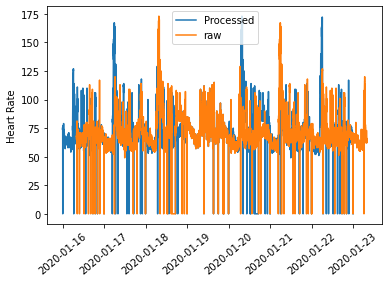

In [10]:
plot_window(window_to_compare["heart_rate"], window_to_compare["start"], window_to_compare["end"],label="Processed")
plot_data_in_range(raw_compare,window_to_compare["start"], window_to_compare["end"],time_offset="8h",label="raw")
plt.legend()
plt.xticks(rotation=40)
plt.ylabel("Heart Rate")

In [11]:
INTERMEDIATE_PATH = "/homes/gws/mikeam/seattleflustudy/new_dataset/split-2020-02-10/train_minute"
intermediate_df = spark.read.parquet(INTERMEDIATE_PATH)
intermediate_compare = intermediate_df.filter(f.col("participant_id") == compare_participant).toPandas()
intermediate_compare = intermediate_compare.sort_values("timestamp")

Text(0, 0.5, 'Heart Rate')

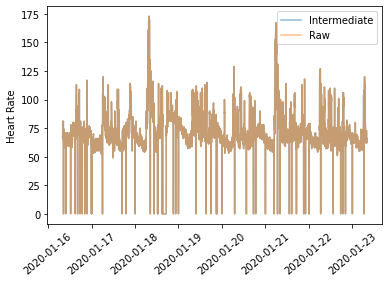

In [12]:
# plot_window(window_to_compare["heart_rate"], window_to_compare["start"], window_to_compare["end"],label="Processed", alpha=0.5)
plot_data_in_range(intermediate_compare,window_to_compare["start"], window_to_compare["end"],time_offset="8h",label="Intermediate", alpha=0.5)
plot_data_in_range(raw_compare,window_to_compare["start"], window_to_compare["end"],time_offset="8h",label="Raw", alpha=0.5)
plt.legend()
plt.xticks(rotation=40)
plt.ylabel("Heart Rate")

Text(0, 0.5, 'Heart Rate')

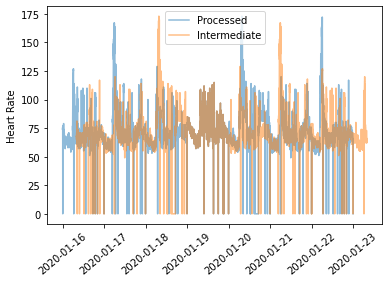

In [13]:
plot_window(window_to_compare["heart_rate"], window_to_compare["start"], window_to_compare["end"],label="Processed", alpha=0.5)
plot_data_in_range(intermediate_compare,window_to_compare["start"], window_to_compare["end"],time_offset="8h",label="Intermediate", alpha=0.5)
# plot_data_in_range(raw_compare,window_to_compare["start"], window_to_compare["end"],time_offset="8h",label="Raw", alpha=0.5)
plt.legend()
plt.xticks(rotation=40)
plt.ylabel("Heart Rate")

We here are some data that were saved during the petastorm generation:

In [14]:
petastorm_gen_debug_df = pd.read_json("peta_debug_intermediate.json")
petastorm_gen_debug_df[["start","end"]] = petastorm_gen_debug_df[["start","end"]].apply(pd.to_datetime,unit="ms")
petastorm_gen_debug_df.head()

,participant_id,window,steps,heart_rate,missing_heart_rate,missing_steps,sleep_classic_0,sleep_classic_1,sleep_classic_2,sleep_classic_3,count_col,start,end
0,5c64f5834a7a8041c0abf089f4866e4f,"[1583424000000, 1583773200000]","[0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0,...","[75.0, 75.0, 76.0, 75.0, 76.0, 77.0, 75.0, 73....","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",5760,2020-03-05 16:00:00,2020-03-09 17:00:00
1,5c64f5834a7a8041c0abf089f4866e4f,"[1580832000000, 1581177600000]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[73.0, 74.0, 73.0, 74.0, 72.0, 72.0, 72.0, 69....","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",5760,2020-02-04 16:00:00,2020-02-08 16:00:00
2,aa1b71f8338af516b159c17776e7bde5,"[1578499200000, 1578844800000]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[77.0, 75.0, 74.0, 73.0, 76.0, 75.0, 76.0, 79....","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",5760,2020-01-08 16:00:00,2020-01-12 16:00:00
3,5c64f5834a7a8041c0abf089f4866e4f,"[1588438800000, 1588784400000]","[8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0,...","[82.0, 75.0, 71.0, 69.0, 72.0, 76.0, 74.0, 75....","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",5760,2020-05-02 17:00:00,2020-05-06 17:00:00
4,001ff8d5662587ed0ccc23a6d249c40c,"[1581609600000, 1581955200000]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[70.0, 71.0, 72.0, 72.0, 73.0, 71.0, 70.0, 70....","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",5760,2020-02-13 16:00:00,2020-02-17 16:00:00


In [15]:
peta_test_user = "5c64f5834a7a8041c0abf089f4866e4f"
peta_test_user_day = petastorm_gen_debug_df[petastorm_gen_debug_df["participant_id"]==peta_test_user].iloc[0]


In [16]:
peta_test_user_day

participant_id                         5c64f5834a7a8041c0abf089f4866e4f
window                                   [1583424000000, 1583773200000]
steps                 [0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0,...
heart_rate            [75.0, 75.0, 76.0, 75.0, 76.0, 77.0, 75.0, 73....
missing_heart_rate    [False, False, False, False, False, False, Fal...
missing_steps         [False, False, False, False, False, False, Fal...
sleep_classic_0       [True, True, True, True, True, True, True, Tru...
sleep_classic_1       [False, False, False, False, False, False, Fal...
sleep_classic_2       [False, False, False, False, False, False, Fal...
sleep_classic_3       [False, False, False, False, False, False, Fal...
count_col                                                          5760
start                                               2020-03-05 16:00:00
end                                                 2020-03-09 17:00:00
Name: 0, dtype: object

In [17]:
raw_peta_compare =  pd.read_parquet("/homes/gws/mikeam/seattleflustudy/data/debug/processed_fitbit_minute_level_activity")

In [18]:
raw_peta_compare = raw_peta_compare.sort_values("timestamp")

Text(0, 0.5, 'Heart Rate')

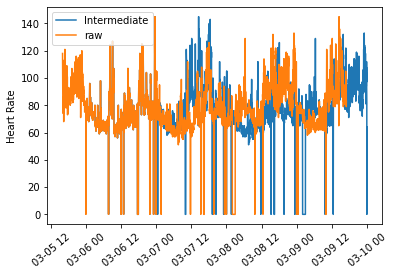

In [19]:
start = peta_test_user_day["start"]
end = peta_test_user_day["end"]
plot_window(peta_test_user_day["heart_rate"], start.date() + pd.to_timedelta("1D") , end.date() + pd.to_timedelta("1D"),label="Intermediate")
plot_data_in_range(raw_peta_compare[raw_peta_compare["participant_id"] == peta_test_user],start,end ,time_offset="0h",label="raw")
plt.legend()
plt.xticks(rotation=40)
plt.ylabel("Heart Rate")

In [20]:
peta_test_user_day["start"].date()

datetime.date(2020, 3, 5)

In [21]:
1+1

2